In [1]:
%cd ..

/Users/pavanpreetgandhi/git-repos/interpretable-sla


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from source.fit_predict_score_utils import fit_and_predict, build_score_df, calibrate_score_df

In [3]:
nof_non_feature_cols = 5  # speaker_id, subset, part, part_score, overall_score

In [4]:
datasets = {}
dataset_paths = sorted([f for f in os.listdir('datasets') if f.endswith('.parquet')])
for dataset_path in dataset_paths:
    dataset_name = os.path.splitext(dataset_path)[0]
    df = pd.read_parquet(os.path.join('datasets', dataset_path))
    if dataset_name != '7_qwen_2_5_omni_embeddings':
        features = df.columns[nof_non_feature_cols:]
        df[features] = np.exp(df[features])
    datasets[os.path.splitext(dataset_path)[0]] = df

In [5]:
experiments = [
    {
        "name": "Original Question Set",
        "dataset": datasets["1_original_question_set"],
        "features": datasets["1_original_question_set"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Direct Scoring with Rubric",
        "dataset": datasets["2_direct_scoring_with_rubric"],
        "features": datasets["2_direct_scoring_with_rubric"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Rubric Based Questions",
        "dataset": datasets["3_rubric_based_questions"],
        "features": datasets["3_rubric_based_questions"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Rubric Based Questions (Batch Inference)",
        "dataset": datasets["4_rubric_based_questions_batch"],
        "features": datasets["4_rubric_based_questions_batch"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Revised Question Set",
        "dataset": datasets["5_revised_question_set"],
        "features": datasets["5_revised_question_set"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Revised Question Set (Batch Inference)",
        "dataset": datasets["6_revised_question_set_batch"],
        "features": datasets["6_revised_question_set_batch"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
]

In [6]:
# Add experiment combining all question sets
combined_dataset = None
combined_features = []
for name, dataset in datasets.items():
    if name == '7_qwen_2_5_omni_embeddings':
        continue
    if combined_dataset is None:
        combined_dataset = dataset
    else:
        assert combined_dataset.index.equals(dataset.index), "Datasets have different indices"
        combined_dataset = pd.concat([combined_dataset, dataset.iloc[:, nof_non_feature_cols:]], axis=1)
    combined_features.extend(dataset.columns[nof_non_feature_cols:])

experiments.append({
    "name": "Combined Question Sets",
    "dataset": combined_dataset,
    "features": combined_features,
    "pipeline": Pipeline([("model", LinearRegression())]),
})
print(f"Combined dataset features: {len(combined_features)}")

Combined dataset features: 204


In [7]:
# Random projections
set_to_project = "1_original_question_set"
nof_projected_features = len(combined_features)
print(f"Projecting {set_to_project} to {nof_projected_features} features")
df = datasets[set_to_project]
features = df.columns[nof_non_feature_cols:]
P = np.random.rand(len(features), nof_projected_features) # Random projection matrix
projected_df = df[features].dot(P)  # shape: (n_samples, nof_projected_features)
projected_df.columns = [f'projected_feature_{i}' for i in range(projected_df.shape[1])]
df_projected = df.copy()
df_projected.drop(columns=features, inplace=True)
df_projected = pd.concat([df_projected, projected_df], axis=1)

experiments.append({
    "name": "Random Projections of Original Question Set",
    "dataset": df_projected,
    "features": projected_df.columns.tolist(),
    "pipeline": Pipeline([("model", LinearRegression())]),
})

Projecting 1_original_question_set to 204 features


In [8]:
# Embeddings
experiments.append({
    "name": "Qwen 2.5 Omni Embeddings",
    "dataset": datasets["7_qwen_2_5_omni_embeddings"],
    "features": datasets["7_qwen_2_5_omni_embeddings"].columns[nof_non_feature_cols:],
    "pipeline": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(2.5, 3.5, 20)))
    ]),
})

In [9]:
# Embeddings + All Question Sets
df_embeddings = datasets["7_qwen_2_5_omni_embeddings"]
features_embeddings = df_embeddings.columns[nof_non_feature_cols:]
df_combined_embeddings = pd.concat([combined_dataset, df_embeddings[features_embeddings]], axis=1)
df_combined_embeddings_features = combined_features + features_embeddings.tolist()
experiments.append({
    "name": "Combined Question Sets + Qwen 2.5 Omni Embeddings",
    "dataset": df_combined_embeddings,
    "features": df_combined_embeddings_features,
    "pipeline": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(3.0, 3.5, 20)))
    ]),
})

In [10]:
PARTS = ["part_1", "part_3", "part_4", "part_5", "overall"]
SUBSETS = ["train", "dev", "eval"]
calibrated_score_dfs = {}
for experiment in experiments:
    print(f"Running experiment: {experiment['name']}")
    predictions, pipelines = fit_and_predict(
        df=experiment["dataset"],
        features=experiment["features"],
        pipeline=experiment["pipeline"],
    )
    score_df = build_score_df(
        df=experiment["dataset"],
        predictions=predictions,
    )
    calibrated_score_df = calibrate_score_df(
        score_df, 
        calibration_set='dev'
    )
    calibrated_score_dfs[experiment["name"]] = calibrated_score_df

Running experiment: Original Question Set
Running experiment: Direct Scoring with Rubric
Running experiment: Rubric Based Questions
Running experiment: Rubric Based Questions (Batch Inference)
Running experiment: Revised Question Set
Running experiment: Revised Question Set (Batch Inference)
Running experiment: Combined Question Sets
Running experiment: Random Projections of Original Question Set
Running experiment: Qwen 2.5 Omni Embeddings
Running experiment: Combined Question Sets + Qwen 2.5 Omni Embeddings


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)

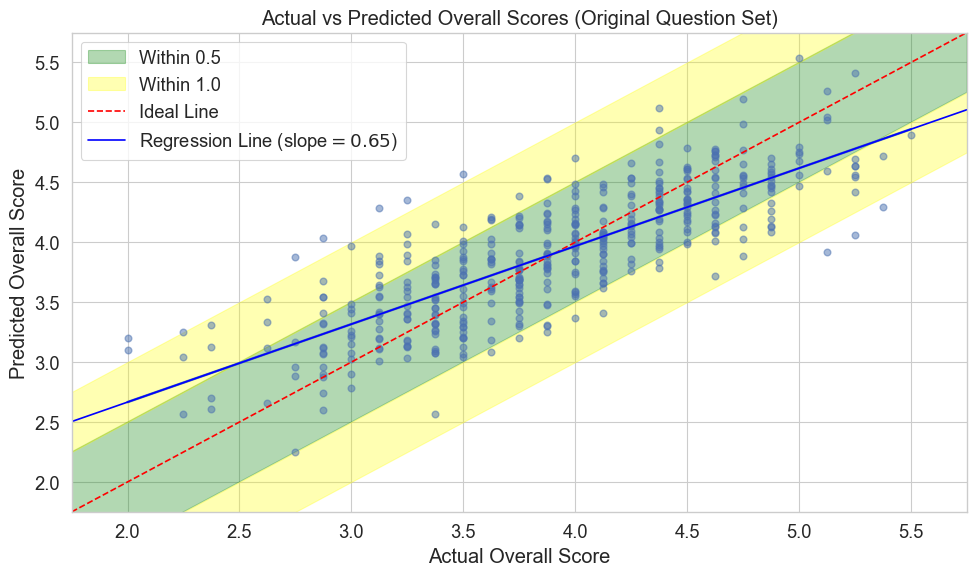

In [17]:
plt.figure(figsize=(10, 6))
plot_df = calibrated_score_dfs['Original Question Set']
plot_df = plot_df[plot_df['subset'] == 'dev'][['overall_pred', 'overall_actual']]

X = plot_df['overall_actual'].values.reshape(-1, 1)
y = plot_df['overall_pred'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]

start, end = 1.75, 5.75
plt.xlim(start, end)
plt.ylim(start, end)
color_05 = 'green'
color_10 = 'yellow'
alpha_range = 0.3
plt.fill_between([start, end], [start-0.5, end-0.5], [start+0.5, end+0.5], color=color_05, alpha=alpha_range, label='Within 0.5')
plt.fill_between([start, end], [start-1, end-1], [start-0.5, end-0.5], color=color_10, alpha=alpha_range, label='Within 1.0')
plt.fill_between([start, end], [start+0.5, end+0.5], [start+1, end+1], color=color_10, alpha=alpha_range)
plt.plot([start, end], [start, end], color='red', linestyle='--', label='Ideal Line')

sns.regplot(
    data=plot_df, 
    x='overall_actual', 
    y='overall_pred', 
    scatter=True,
    ci=None,
    label=None,  # No label for scatter/regression line
    scatter_kws={'alpha': 0.5}
)
plt.plot(
    [start, end], 
    reg.predict(np.array([start, end]).reshape(-1, 1)), 
    color='blue', 
    label=f'Regression Line (slope$={slope:.2f}$)'
)

plt.xlabel('Actual Overall Score')
plt.ylabel('Predicted Overall Score')

plt.title('Actual vs Predicted Overall Scores (Original Question Set)')
plt.legend()

plt.tight_layout()
plt.savefig('report/images/actual_vs_predicted_orig.png', dpi=300, bbox_inches='tight')

plt.show()

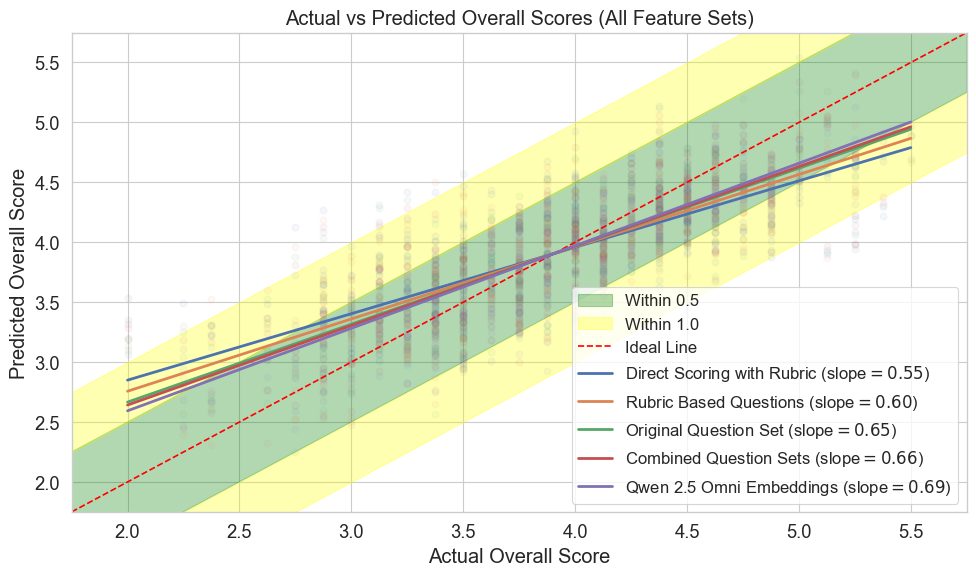

In [18]:
plt.figure(figsize=(10, 6))

start, end = 1.75, 5.75
plt.xlim(start, end)
plt.ylim(start, end)
color_05 = 'green'
color_10 = 'yellow'
alpha_range = 0.3
plt.fill_between([start, end], [start-0.5, end-0.5], [start+0.5, end+0.5], color=color_05, alpha=alpha_range, label='Within 0.5')
plt.fill_between([start, end], [start-1, end-1], [start-0.5, end-0.5], color=color_10, alpha=alpha_range, label='Within 1.0')
plt.fill_between([start, end], [start+0.5, end+0.5], [start+1, end+1], color=color_10, alpha=alpha_range)
plt.plot([start, end], [start, end], color='red', linestyle='--', label='Ideal Line')

experiment_names = [
    "Direct Scoring with Rubric", 
    "Rubric Based Questions", 
    "Original Question Set", 
    # "Revised Question Set", 
    "Combined Question Sets",
    "Qwen 2.5 Omni Embeddings"
]
for experiment_name in experiment_names:
    plot_df = calibrated_score_dfs[experiment_name]
    plot_df = plot_df[plot_df['subset'] == 'dev'][['overall_pred', 'overall_actual']]

    X = plot_df['overall_actual'].values.reshape(-1, 1)
    y = plot_df['overall_pred'].values
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]

    sns.regplot(
        data=plot_df, 
        x='overall_actual', 
        y='overall_pred', 
        scatter=True,
        ci=None,
        line_kws={'linewidth': 2, 'label': f'{experiment_name} (slope$={slope:.2f}$)'}, # (nof features$={len([experiment for experiment in experiments if experiment["name"] == experiment_name][0]['features'])}$)'},
        scatter_kws={'alpha': 0.05}
    )

plt.xlabel('Actual Overall Score')
plt.ylabel('Predicted Overall Score')

plt.title('Actual vs Predicted Overall Scores (All Feature Sets)')
plt.legend(fontsize='small')

plt.tight_layout()
plt.savefig('report/images/actual_vs_predicted_all.png', dpi=300, bbox_inches='tight')

plt.show()